In [1]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

In [2]:
CSV_PATH = Path("../cleaned_data/keywords_cleaned.csv")

df = pd.read_csv(CSV_PATH, low_memory=False)
df.shape, df.head()

((31092, 2),
       id                                           keywords
 0    862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
 1   8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
 2  15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
 3  31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
 4  11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...)

In [3]:
print("Shape:", df.shape)

print("\nDtypes:")
display(df.dtypes.to_frame("dtype"))

print("\nMissing values:")
na = df.isna().sum().rename("missing")
display(
    pd.concat([na, (na/len(df)*100).rename("missing_%").round(2)], axis=1)
     .sort_values("missing_%", ascending=False)
)

# Numeric zero counts (dataset is mostly id + keywords, but keep this for completeness)
print("\nZero counts in numeric columns:")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    z = pd.Series({c: int((df[c] == 0).sum()) for c in num_cols}, name="zero_count")
    display(z.sort_values(ascending=False).to_frame())
else:
    print("No numeric columns.")

# ---- Parse JSON-like keywords and check for empty structures ----
def safe_parse(x):
    """Parse JSON-like string; return [] on blank/invalid."""
    if pd.isna(x) or not isinstance(x, str) or not x.strip():
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

if 'keywords' in df.columns:
    df['keywords_parsed'] = df['keywords'].apply(safe_parse)
    empty_keywords = (df['keywords_parsed'].apply(len) == 0).sum()
    null_or_blank = df['keywords'].isna().sum() + (df['keywords'].astype(str).str.strip() == '').sum()
    print(f"\nkeywords — null/blank: {null_or_blank}, empty after parse ([]): {empty_keywords}")

    # Optional: how many keywords per row
    df['keyword_count'] = df['keywords_parsed'].apply(len)
    print("\nKeyword count summary:")
    display(df['keyword_count'].describe().to_frame('keyword_count'))


Shape: (31092, 2)

Dtypes:


,dtype
id,int64
keywords,object



Missing values:


,missing,missing_%
id,0,0.0
keywords,0,0.0



Zero counts in numeric columns:


,zero_count
id,0



keywords — null/blank: 0, empty after parse ([]): 0

Keyword count summary:


,keyword_count
count,31092.000000
mean,5.036730
std,4.912728
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,149.000000


In [4]:
import json

def make_hashable(x):
    """Turn lists/dicts/sets/ndarrays into hashable forms for nunique/duplicated."""
    if isinstance(x, (list, dict, set)):
        return json.dumps(x, sort_keys=True)
    if isinstance(x, np.ndarray):
        return tuple(x.tolist())
    return x

print("Unique values per column (robust):")
unique_counts = {}
for col in df.columns:
    s = df[col]
    if s.dtype == 'object':
        unique_counts[col] = s.map(make_hashable).nunique(dropna=False)
    else:
        unique_counts[col] = s.nunique(dropna=False)
display(pd.Series(unique_counts, name="n_unique").sort_values(ascending=False).to_frame())

# Fully duplicated rows (convert unhashables on a copy)
df_for_dups = df.copy()
for col in df_for_dups.select_dtypes(include=['object']).columns:
    df_for_dups[col] = df_for_dups[col].map(make_hashable)

dup_rows = int(df_for_dups.duplicated().sum())
print(f"\nDuplicate rows (entire row identical): {dup_rows}")

# Column-specific duplicates
if 'id' in df.columns:
    print("Duplicate IDs:", int(df['id'].duplicated().sum()))

if 'keywords' in df.columns:
    dup_keywords = int(df['keywords'].map(make_hashable).duplicated().sum())
    print("Duplicate keyword lists:", dup_keywords)


Unique values per column (robust):


,n_unique
id,31092
keywords,25988
keywords_parsed,25988
keyword_count,56



Duplicate rows (entire row identical): 0
Duplicate IDs: 0
Duplicate keyword lists: 5104


Top 20 most frequent keywords:


,keyword,count
0,woman director,3039
1,independent film,1914
2,murder,1285
3,based on novel,822
4,musical,726
5,sex,679
6,violence,647
7,nudity,629
8,revenge,618
9,biography,613


<Figure size 1000x600 with 0 Axes>

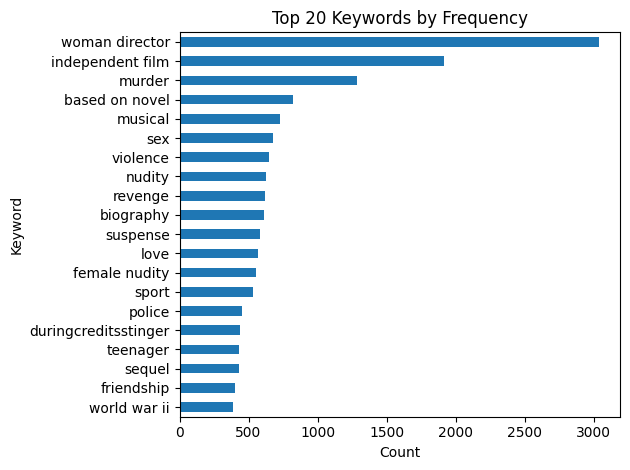

In [5]:
if 'keywords_parsed' not in df.columns:
    print("No parsed keyword data found. Please run the previous cell first.")
else:
    # Flatten all keywords into one list
    all_keywords = [kw['name'] for sublist in df['keywords_parsed'] for kw in sublist if isinstance(kw, dict) and 'name' in kw]
    keywords_series = pd.Series(all_keywords)
    
    # Frequency table
    keyword_counts = keywords_series.value_counts().reset_index()
    keyword_counts.columns = ['keyword', 'count']
    
    print("Top 20 most frequent keywords:")
    display(keyword_counts.head(20))
    
    # Plot
    plt.figure(figsize=(10, 6))
    keyword_counts.head(20).plot(kind='barh', x='keyword', y='count', legend=False)
    plt.title("Top 20 Keywords by Frequency")
    plt.xlabel("Count")
    plt.ylabel("Keyword")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
